In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import matplotlib
#%matplotlib notebook 

## Rappel des edges et parcours :

```
# class IssyOSMNetwork(Network):

    def specify_routes(self, net_params):
        return {
            "-100822066": [ #N
                "-100822066",
                "-352962858#1",
                "-352962858#0",
                "-4786940#1",
                "-4786940#0",
            ],
            
            "4794817" : [ #Loop
                "4794817",
                "4786972#0",
                "4786972#1",
                "4786972#2",
                "4786965#1",
                "4786965#2",
                "4786965#3",
                "4786965#4",
                "4786965#5",   
            ],
            
            "4783299#0" : [ #Loop bis
                "4783299#0",
                "4783299#1",
                "4783299#2",
                "4783299#3",
                "4783299#4",
                "4783299#5",
                "4783299#6",
                "4786940#0",
                "4786940#1",
                "352962858#0",
                "4795742#0", #??
                "4795742#1",
                "4786965#3",
                "4795729",
                "100822066",    
            ],
            
            "155558218": [     #SE
                "155558218",
                "4786940#1",
                "352962858#0",
                "352962858#1",
                "100822066",
            ], 
        }
```



# Compare Resultats

In [ ]:
# fonction calculant l'accélération des véhicules à chaque step
# et leur temps d'attente à chaque step
def get_acc_wait(df):
  
  df_acc = len(df) * [0]
  df_wait = [0.2 if v == 0 else 0 for v in df.speed]

  for i in range(1, len(df)):

    if (df.loc[i, 'id'] == df.loc[i-1, 'id']):

      d_v = df.loc[i, 'speed'] - df.loc[i-1, 'speed']
      d_t = df.loc[i, 'time'] - df.loc[i-1, 'time']
      acc = d_v / d_t

      df_acc[i] = acc
  df['acc'] = df_acc
  df['wait'] = df_wait
  df['acc_pos'] = df['acc'].apply(lambda x : x if x >= 0 else 0)
  
  return df

In [ ]:
def clean_df(df):
  df_clean = df.drop(columns=['electricity','CO','y','x','relative_position','type','eclass','NOx',
                        'noise','angle','PMx','HC'])
  df_clean = get_acc_wait(df_clean)
  
  return df_clean

In [ ]:
import glob
path = '/content/drive/My Drive/CIL4SYS/emission/*.csv'
df = {}
df_stats = {}
for file_path in tqdm(glob.glob(path)):
    name           = file_path.replace('/content/drive/My Drive/CIL4SYS/emission/', '')
    df[name]       = pd.read_csv(file_path)
    df[name]       = clean_df(df[name])

100%|██████████| 18/18 [01:02<00:00,  3.49s/it]


In [ ]:
def get_properties(dict):
  i=0
  size = len(dict)
  columns=['name','num_vhl','avg_speed','std_speed','avg_acc','std_acc',
           'avg_acc_pos','std_acc_pos', 'integer_acc_pos', 'avg_wait','std_wait']
  zero_data = np.zeros(shape=(size,len(columns)))
  df_results = pd.DataFrame(zero_data, columns=columns)

  for key, value in dict.items():
    df_results['name'][i] = key
    df_results['num_vhl'][i] = len(value.id.unique())
    df_results['avg_speed'][i] = np.mean(value.speed)
    df_results['std_speed'][i] = np.std(value.speed)
    df_results['avg_acc'][i] = np.mean(value.acc)
    df_results['std_acc'][i] = np.std(value.acc)
    df_results['avg_acc_pos'][i] = np.mean(value.acc_pos)
    df_results['std_acc_pos'][i] = np.std(value.acc_pos)
    df_results['integer_acc_pos'][i] = np.sum(value.acc_pos) * 0.2

    # Calcul du temps moyen d'attente par vhl
    list_vhl_id  = value.id.unique()
    list_wait_vhl = []
    for vhl in list_vhl_id:
      list_wait_vhl.append(np.sum(value[(value['id']== vhl)].wait))

    df_results['avg_wait'][i] = np.mean(list_wait_vhl)
    df_results['std_wait'][i] = np.std(list_wait_vhl)
    i+=1

  return df_results

In [ ]:
df_results = get_properties(df)
df_results = df_results.sort_index(ascending=False)
df_results = df_results.reset_index().drop(columns='index')
df_results

,name,num_vhl,avg_speed,std_speed,avg_acc,std_acc,avg_acc_pos,std_acc_pos,integer_acc_pos,avg_wait,std_wait
0,Reference_ISSY_traffic_20200526-emission.csv,113.0,4.355959,4.860218,0.035767,1.173870,0.209399,0.456113,2334.63,30.768142,25.684768
1,emission_04_06_2020_IssyEnv2_PPO.csv,199.0,4.920693,6.032023,0.081567,1.235075,0.194678,0.757241,3221.80,42.101508,74.377105
2,emission_04_06_2020_IssyEnv1_DQN.csv,198.0,4.775912,5.949407,0.082179,1.054991,0.191639,0.583288,3182.43,41.237374,72.051985
3,emission_2020-05-27_PPO_Env2.csv,170.0,3.350837,4.303498,-0.029221,0.947444,0.157592,0.415024,2733.68,40.301176,30.002590
4,emission_2020-05-27_PPO_Env1.csv,177.0,4.710275,4.891135,0.006330,1.064542,0.224132,0.472840,3239.06,24.047458,28.431152
5,emission_2020-05-27_DQN_Env2.csv,172.0,4.852349,5.998469,0.087951,0.891933,0.196068,0.473308,2536.96,38.272093,62.704604
6,emission_2020-05-26_01.csv,173.0,4.894853,5.876061,0.083804,1.008399,0.196394,0.519449,2585.45,35.350289,59.632703
7,emission_2020-05-26.csv,177.0,5.010020,4.981883,0.018152,1.221236,0.243055,0.748918,3429.31,20.389831,25.776074
8,emission_2020-05-17.csv,124.0,6.157330,5.440625,0.092947,1.691829,0.325385,0.787538,2942.20,13.945161,22.078268
9,emission_2020-05-16.csv,120.0,2.963572,4.764241,-0.025346,1.088207,0.126698,0.534290,1618.06,63.326667,54.244883


In [ ]:
df_results.to_csv('/content/drive/My Drive/CIL4SYS/results.csv')

In [ ]:
# On normalise les résultats pour faciliter les comparaisons
df_test = df_results[['name','avg_speed','avg_acc','avg_acc_pos', 'integer_acc_pos', 'avg_wait']].copy()
min_max_scaler = preprocessing.MinMaxScaler()
test = min_max_scaler.fit_transform(df_test[['avg_speed','avg_acc','avg_acc_pos', 'integer_acc_pos', 'avg_wait']])
df_test[['avg_speed','avg_acc','avg_acc_pos', 'integer_acc_pos', 'avg_wait']] = test
df_test

,name,avg_speed,avg_acc,avg_acc_pos,integer_acc_pos,avg_wait
0,Reference_ISSY_traffic_20200526-emission.csv,0.445878,0.437123,0.544535,0.578916,0.249248
1,emission_04_06_2020_IssyEnv2_PPO.csv,0.558030,0.693271,0.486726,0.920178,0.417163
2,emission_04_06_2020_IssyEnv1_DQN.csv,0.529278,0.696692,0.474793,0.905034,0.404360
3,emission_2020-05-27_PPO_Env2.csv,0.246268,0.073671,0.341094,0.732416,0.390489
4,emission_2020-05-27_PPO_Env1.csv,0.516243,0.272493,0.602388,0.926818,0.149675
5,emission_2020-05-27_DQN_Env2.csv,0.544458,0.728971,0.492185,0.656745,0.360427
6,emission_2020-05-26_01.csv,0.552899,0.705778,0.493466,0.675397,0.317137
7,emission_2020-05-26.csv,0.575770,0.338609,0.676698,1.000000,0.095484
8,emission_2020-05-17.csv,0.803617,0.756912,1.000000,0.812626,0.000000
9,emission_2020-05-16.csv,0.169360,0.095339,0.219778,0.303277,0.731634


In [ ]:
# On réarrange le dataframe en classant selon la vitesse moyenne maximale
# On conserve en premier le csv de référence
df_test[1:] = np.array(df_test[1:].sort_values(['avg_speed'], ascending=[False]))

In [ ]:
df_test.to_csv('/content/drive/My Drive/CIL4SYS/results.csv')
df_test

,name,avg_speed,avg_acc,avg_acc_pos,integer_acc_pos,avg_wait
0,Reference_ISSY_traffic_20200526-emission.csv,0.445878,0.437123,0.544535,0.578916,0.249248
1,emission_2020-05-18_17.csv,1.000000,0.818418,0.937231,0.803302,0.018546
2,emission_2020-05-18_08.csv,0.965552,1.000000,0.875919,0.577508,0.113363
3,emission_2020-05-18_18.csv,0.949999,0.837325,0.790850,0.522278,0.108113
4,emission_2020-05-19_08.csv,0.903820,0.674866,0.825167,0.627064,0.092943
5,emission_2020-05-17.csv,0.803617,0.756912,1.000000,0.812626,0.000000
6,emission_2020-05-26.csv,0.575770,0.338609,0.676698,1.000000,0.095484
7,emission_04_06_2020_IssyEnv2_PPO.csv,0.558030,0.693271,0.486726,0.920178,0.417163
8,emission_2020-05-26_01.csv,0.552899,0.705778,0.493466,0.675397,0.317137
9,emission_2020-05-27_DQN_Env2.csv,0.544458,0.728971,0.492185,0.656745,0.360427


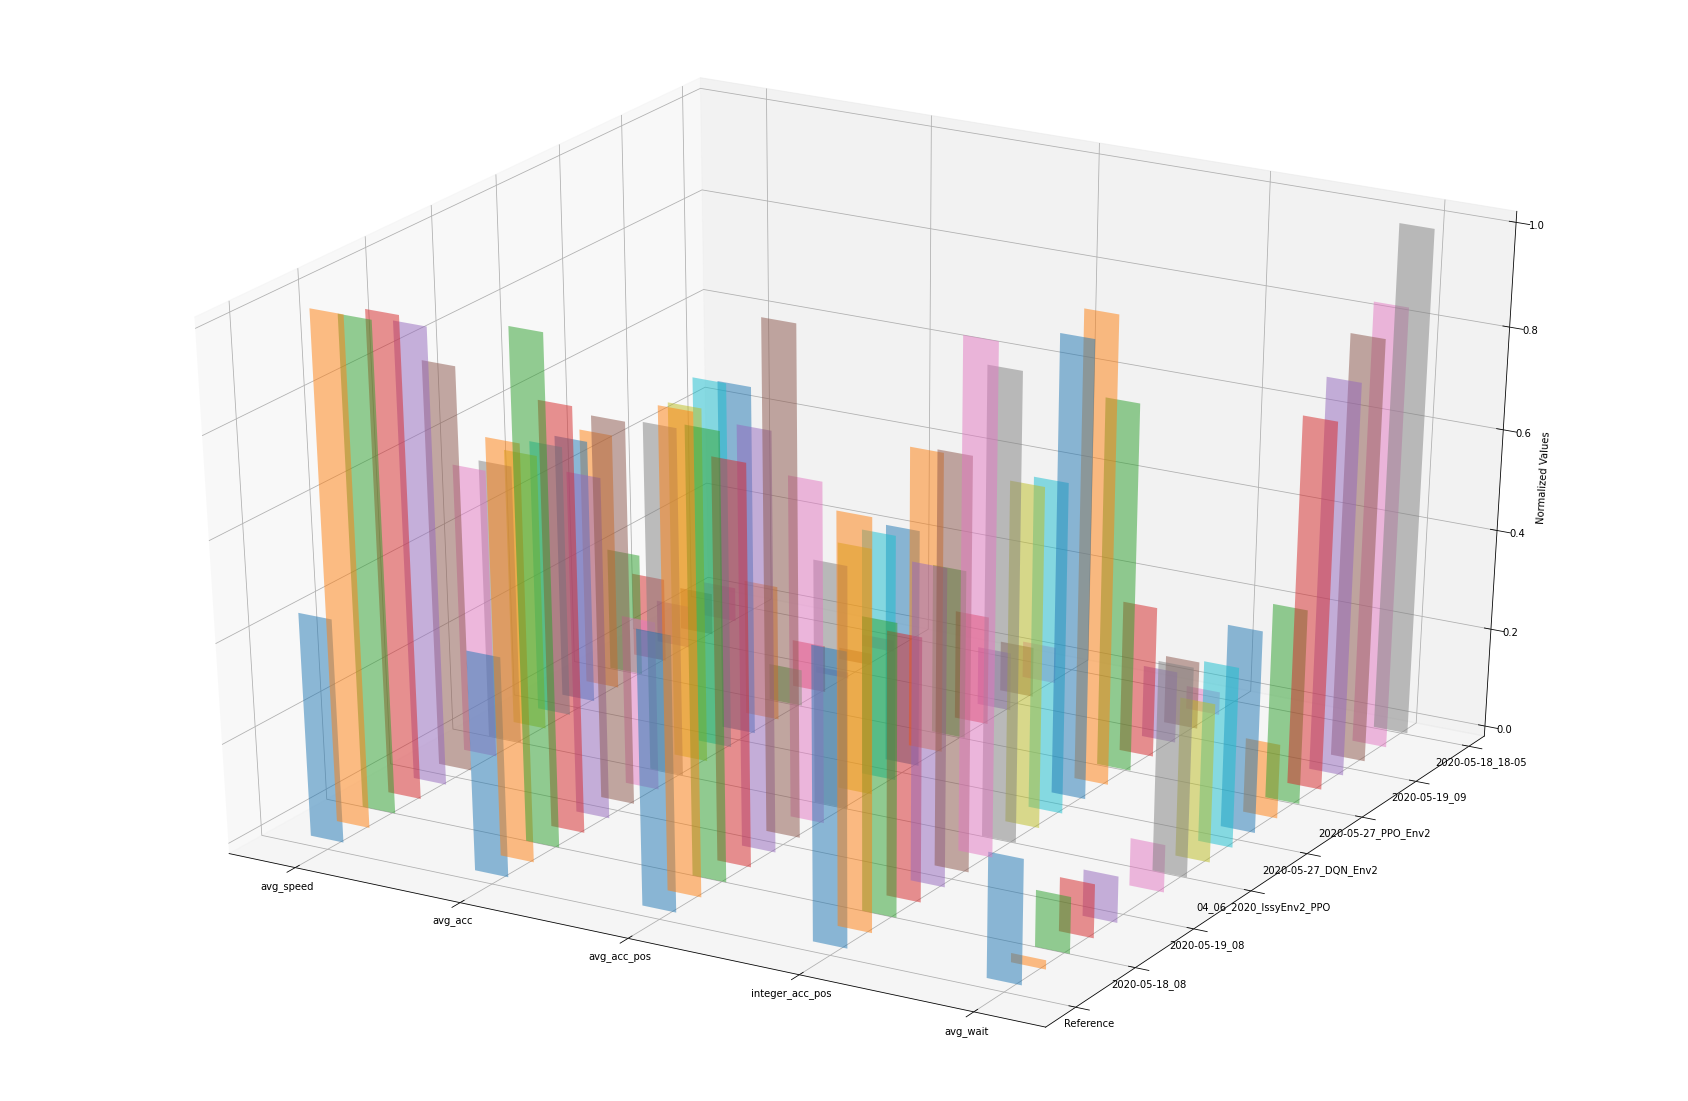

In [ ]:
# DataViz des résultats
df_3d = df_test.transpose() #df_results[['avg_speed','avg_acc','avg_acc_pos','avg_wait']].transpose()

fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111, projection='3d')

z = list(df_3d)
for n, i in enumerate(df_3d):
    xs = ['avg_speed','avg_acc','avg_acc_pos', 'integer_acc_pos', 'avg_wait'] #np.arange(len(df_3d[i]))
    ys = [i for i in df_3d[i][1:]] #ys = df_results['name']
    zs = z[n]

    ax.bar(xs, ys, zs, zdir='y', alpha=0.5, width=0.2)


#ax.set_xlabel('Average Results')
#ax.set_ylabel('DataFrames Index')
ax.set_zlabel('Normalized Values')
ax.set_yticklabels(['Ref','Reference','2020-05-18_08','2020-05-19_08','04_06_2020_IssyEnv2_PPO','2020-05-27_DQN_Env2','2020-05-27_PPO_Env2','2020-05-19_09','2020-05-18_18-05'])

plt.show()#

Au regard des résultats obtenus, on privilégie l'étude du df4, soit le csv = 'emission_2020-05-18_17.csv'

# Analyse détaillée

In [ ]:
# Choix du df à étudier plus en détail
df = df.get('emission_2020-05-18_18.csv').copy()

In [ ]:
# Combien de véhicule ont circulé durant la simulation :
print ("Le nombre de véhicules ayant circulés est de : {}".format(len(df.id.unique())))

Le nombre de véhicules ayant circulés est de : 118


In [ ]:
# calcul vitesse moyenne et écart type
print("La vitesse moyenne de l'ensemble des véhicules pour cette simulation est de : {} m/s".format(np.mean(df.speed)))
print("L'écart-type de la vitesse est de : {}".format(np.std(df.speed)))

La vitesse moyenne de l'ensemble des véhicules pour cette simulation est de : 6.972739784729317 m/s
L'écart-type de la vitesse est de : 6.300048244069996


In [ ]:
# calcul temps d'attente moyen par véhicule
list_vhl_id  = df.id.unique()
list_wait_vhl = []
for vhl in list_vhl_id:
  list_wait_vhl.append(np.sum(df[(df['id']== vhl)].wait))

In [ ]:
print("Le temps d'attente moyen par véhicule est de : {}".format(np.mean(list_wait_vhl)))
print("L'écart-type est de : {}".format(np.std(list_wait_vhl)))

Le temps d'attente moyen par véhicule est de : 21.596610169491527
L'écart-type est de : 54.555000908278515


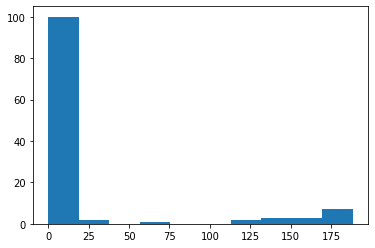

In [ ]:
plt.hist(list_wait_vhl);

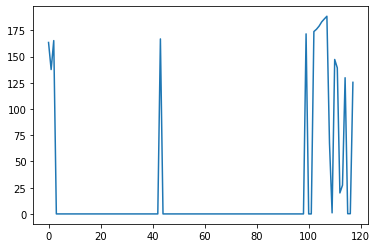

In [ ]:
plt.plot(list_wait_vhl)
plt.show()

In [ ]:
# calcul de l'accélération moyenne de l'ensemble des VHL
print("L'accélération moyenne des véhicules durant la simulation est de : {}".format(np.mean(df.acc)))
print("L'écart-type est de : {}".format(np.std(df.acc)))

L'accélération moyenne des véhicules durant la simulation est de : 0.13641230369791116
L'écart-type est de : 1.7112681542818424


In [ ]:
# calcul de l'accélération moyenne des accélérations exclusivement positives pour l'ensemble des VHL
print("L'accélération moyenne des accélérations uniquement positives est de : {}".format(np.mean(df.acc_pos)))
print("L'écart-type est de : {}".format(np.std(df.acc_pos)))

L'accélération moyenne des accélérations uniquement positives est de : 0.293787653449628
L'écart-type est de : 0.8138971133897711


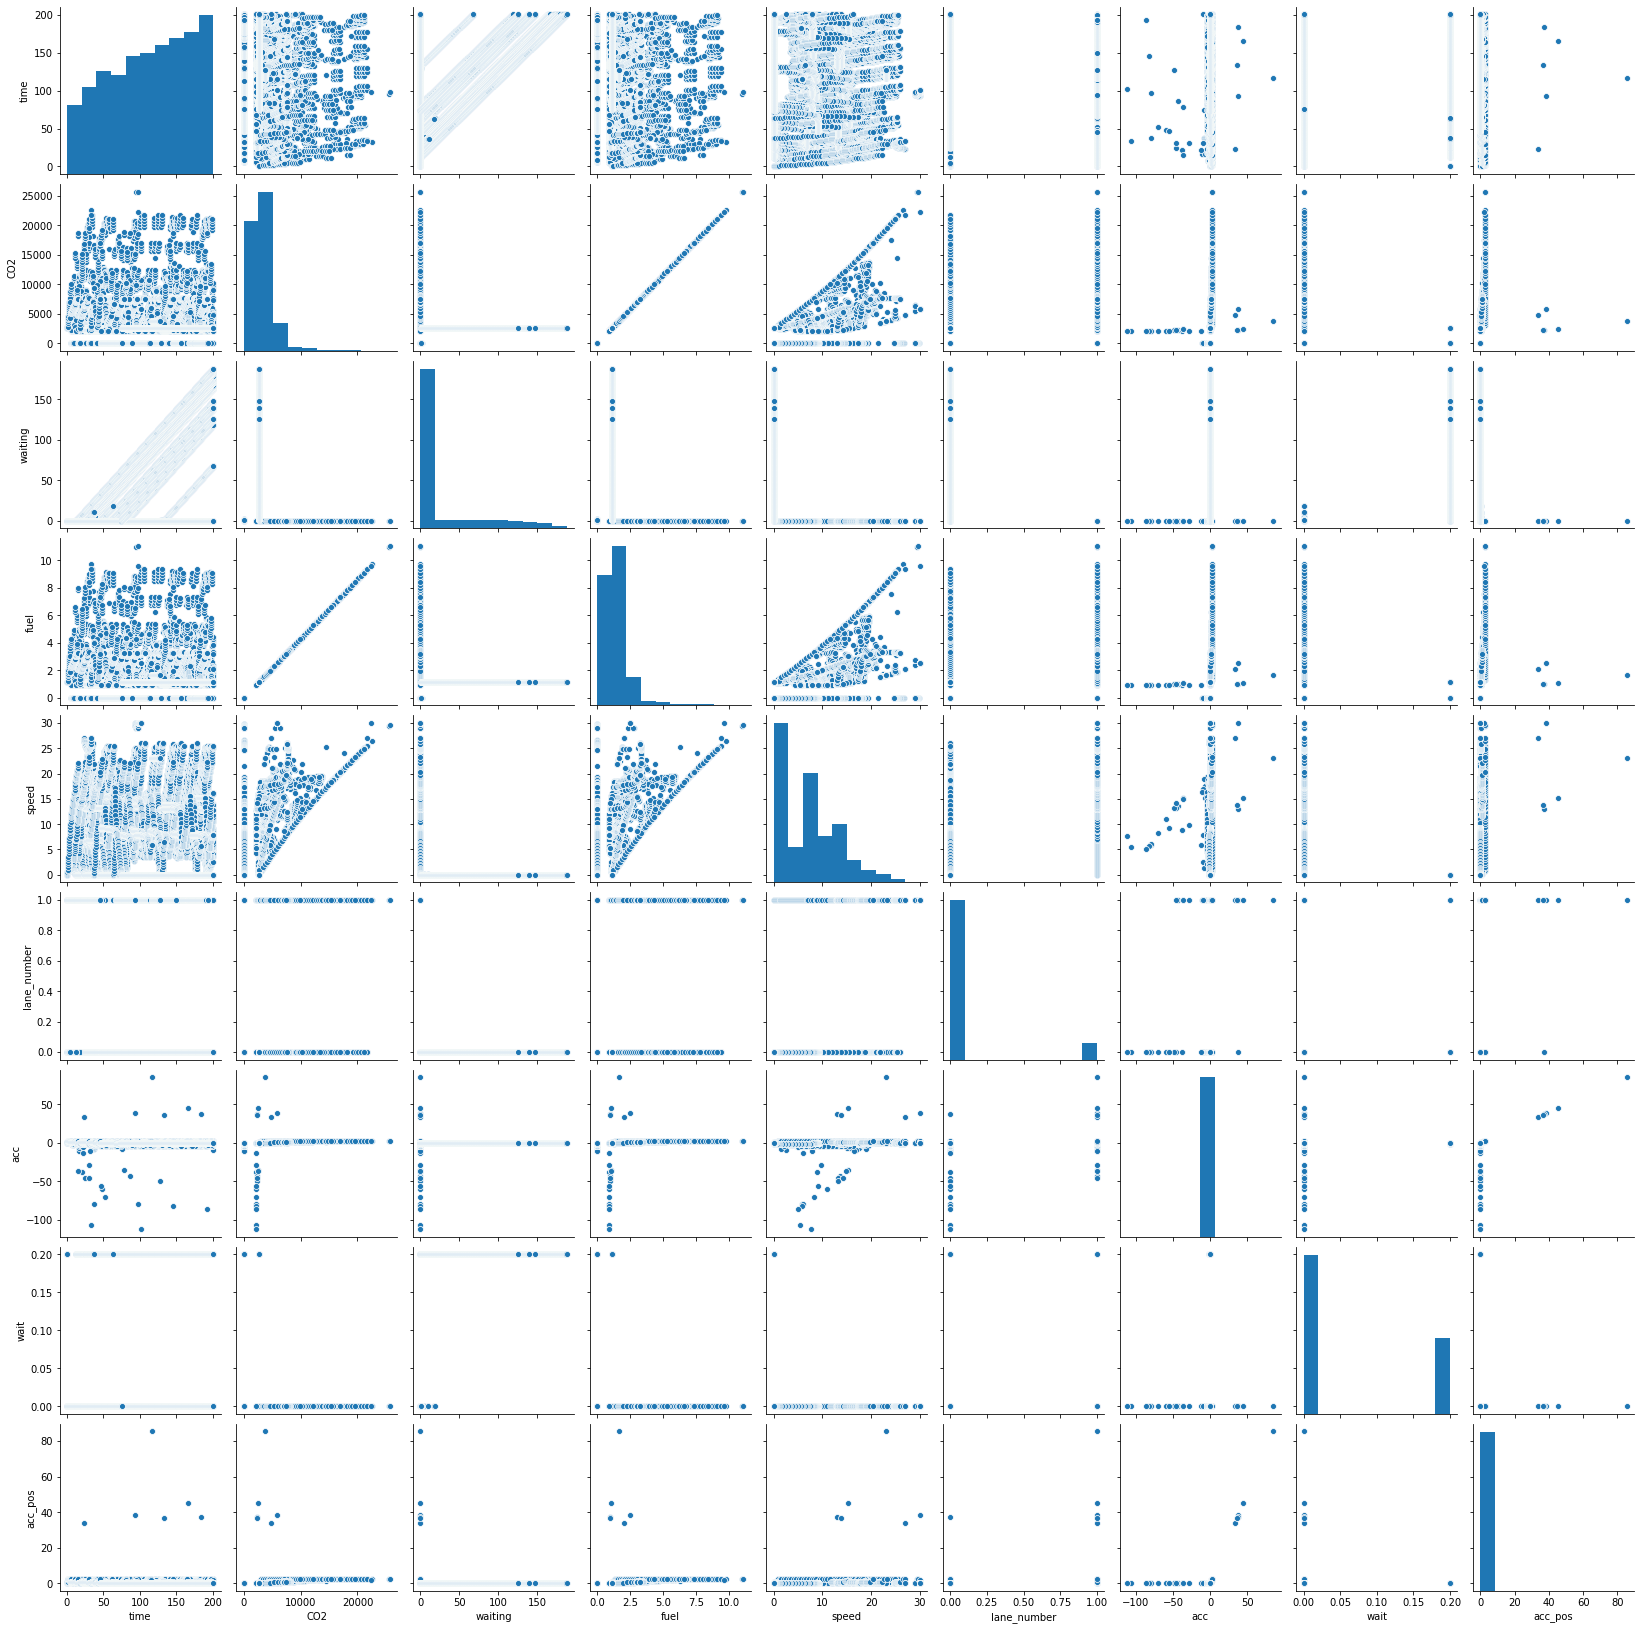

In [ ]:
sns.pairplot(df)

In [ ]:
#create a data frame dictionary to store your data frames
DataFrameDict = {vhl : pd.DataFrame for vhl in list_vhl_id}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df[:][df.id == key]

In [ ]:
def plot_data_vhl(dictdf, vhl):
  fig, axs = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=False)

  axs[0].plot(dictdf[vhl].time, dictdf[vhl].speed)
  axs[0].set_title("Vitesse {} en m/s".format(vhl))
  axs[0].set_xlabel("secondes")

  axs[1].plot(dictdf[vhl].time, np.cumsum(dictdf[vhl].wait))
  axs[1].set_title("Temps d'attente {}".format(vhl))
  axs[1].set_xlabel("secondes")

  axs[2].plot(dictdf[vhl].time, dictdf[vhl].acc)
  axs[2].set_title("Accélération {}".format(vhl))
  axs[2].set_xlabel("secondes")

  axs[3].plot(dictdf[vhl].time, dictdf[vhl].acc_pos)
  axs[3].set_title("Accélération positive {}".format(vhl))
  axs[3].set_xlabel("secondes")

  axs[4].plot(dictdf[vhl].time, dictdf[vhl].CO2)
  axs[4].set_title("CO2 {}".format(vhl))
  axs[4].set_xlabel("secondes")

  plt.show()

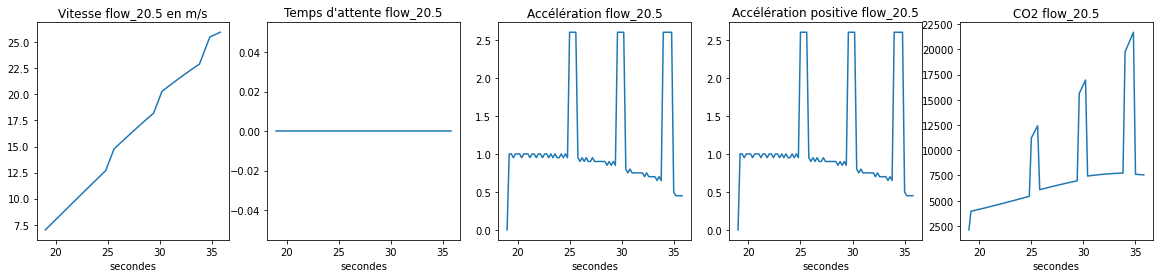

In [ ]:
plot_data_vhl(DataFrameDict,'flow_20.5')

# Test New Issy

In [ ]:
import glob
path = '/content/drive/My Drive/CIL4SYS/Emission_new_Issy/*.csv'
df = {}
df_stats = {}
for file_path in tqdm(glob.glob(path)):
    name           = file_path.replace('/content/drive/My Drive/CIL4SYS/Emission_new_Issy/', '')
    df[name]       = pd.read_csv(file_path)
    df[name]       = clean_df(df[name])

100%|██████████| 2/2 [00:08<00:00,  4.07s/it]


In [ ]:
df_results = get_properties(df)
df_results = df_results.sort_index(ascending=False)
df_results = df_results.reset_index().drop(columns='index')
df_results

,name,num_vhl,avg_speed,std_speed,avg_acc,std_acc,avg_acc_pos,std_acc_pos,integer_acc_pos,avg_wait,std_wait
0,Reference_Issy_Env2.csv,176.0,4.640701,4.785379,0.014581,1.036561,0.229828,0.474933,3149.790000,20.150000,23.082092
1,emission_2020-06-17_PPO_Env2_no_constraint.csv,198.0,4.896988,5.130387,0.028289,1.505971,0.265364,0.697645,4049.984286,11.625253,22.617164


In [ ]:
# On normalise les résultats pour faciliter les comparaisons
df_test = df_results[['name','avg_speed','avg_acc','avg_acc_pos', 'integer_acc_pos', 'avg_wait']].copy()
test = preprocessing.normalize(df_test[['avg_speed','avg_acc','avg_acc_pos', 'integer_acc_pos', 'avg_wait']],axis=0)
df_test[['avg_speed','avg_acc','avg_acc_pos', 'integer_acc_pos', 'avg_wait']] = test
df_test

,name,avg_speed,avg_acc,avg_acc_pos,integer_acc_pos,avg_wait
0,emission_2020-06-17_PPO_Env2_no_constraint.csv,0.725845,0.888877,0.755907,0.789371,0.499731
1,Reference_Issy_Env2.csv,0.687858,0.458145,0.654680,0.613917,0.866181


In [ ]:
# Inversion du dataframe pour mettre en premier le csv de référence
df_test = df_test.iloc[::-1].reset_index(drop=True)#.drop(columns=['index'])
df_test

,name,avg_speed,avg_acc,avg_acc_pos,integer_acc_pos,avg_wait
0,Reference_Issy_Env2.csv,0.687858,0.458145,0.654680,0.613917,0.866181
1,emission_2020-06-17_PPO_Env2_no_constraint.csv,0.725845,0.888877,0.755907,0.789371,0.499731


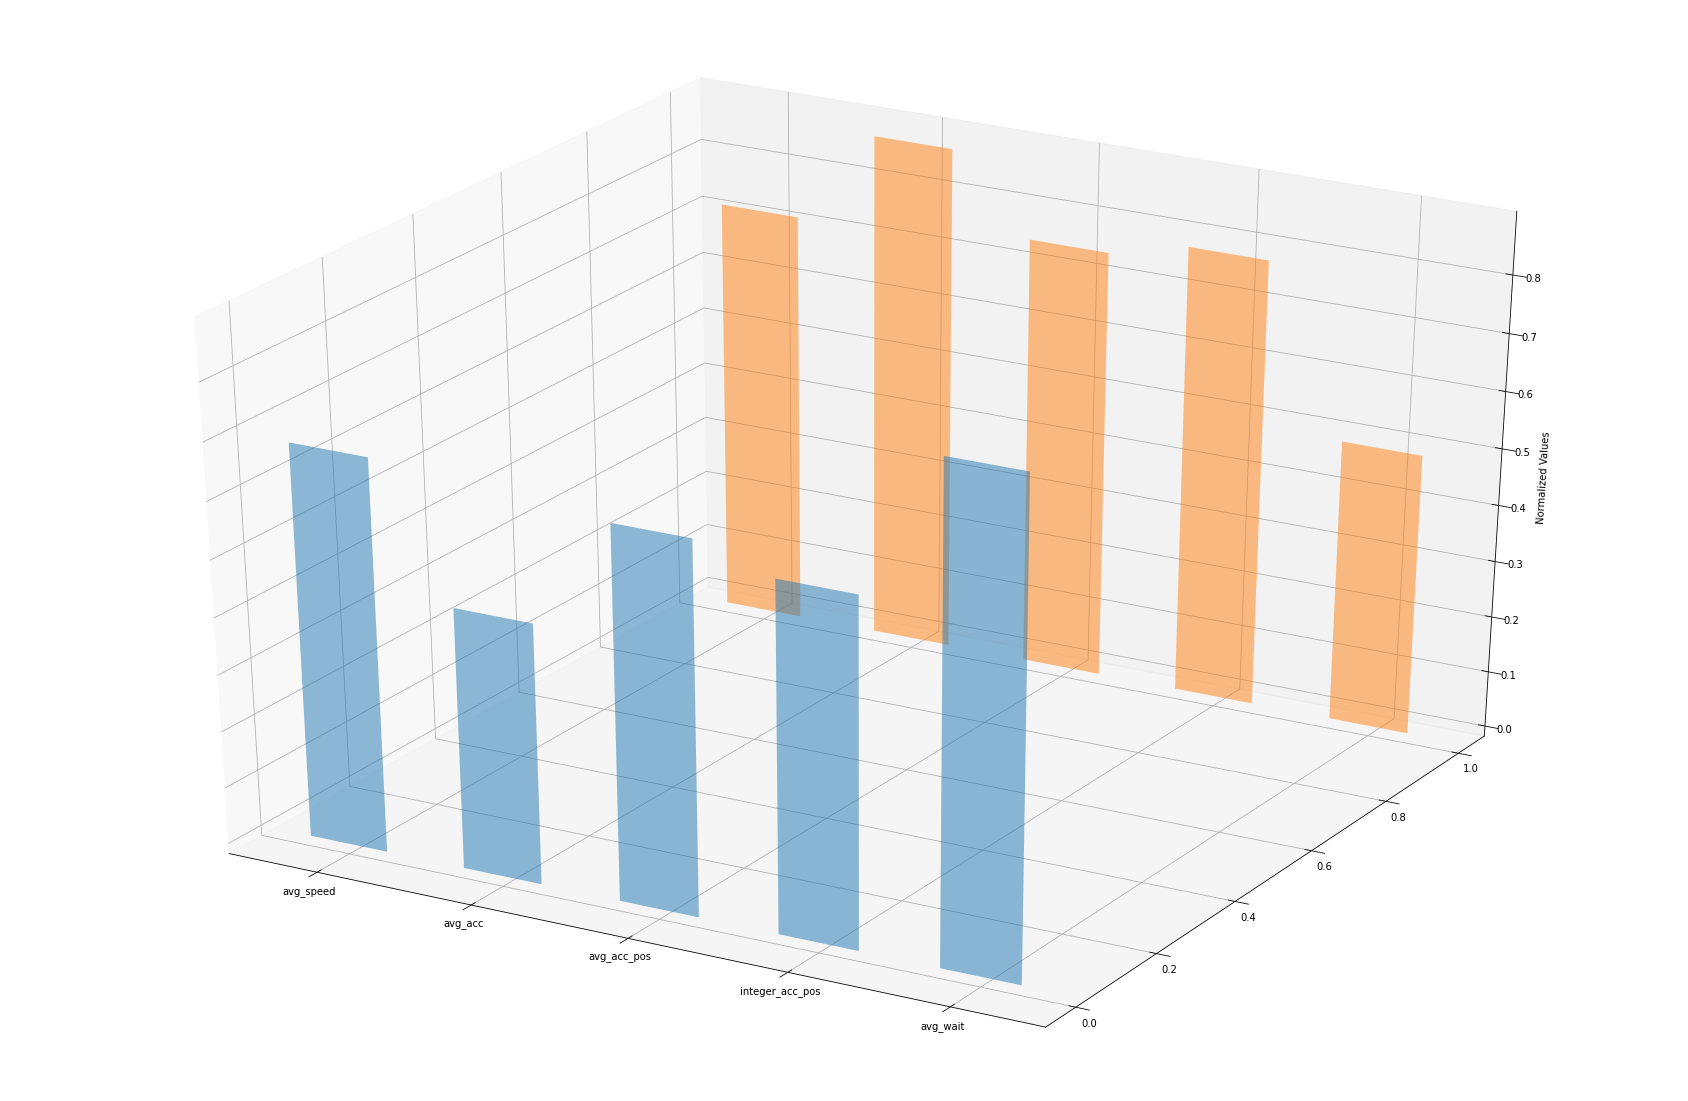

In [ ]:
# DataViz des résultats
df_3d = df_test.transpose() 

fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111, projection='3d')

z = list(df_3d)
for n, i in enumerate(df_3d):
    xs = ['avg_speed','avg_acc','avg_acc_pos', 'integer_acc_pos', 'avg_wait'] 
    ys = [i for i in df_3d[i][1:]] 
    zs = z[n]

    ax.bar(xs, ys, zs, zdir='y', alpha=0.5, width=0.5)

ax.set_zlabel('Normalized Values')

plt.show()#

# Test Carrefour

In [ ]:
import glob
path = '/content/drive/My Drive/CIL4SYS/Emission_Carrefour/*.csv'
df = {}
df_stats = {}
for file_path in tqdm(glob.glob(path)):
    name           = file_path.replace('/content/drive/My Drive/CIL4SYS/Emission_Carrefour/', '')
    df[name]       = pd.read_csv(file_path)
    df[name]       = clean_df(df[name])

100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


In [ ]:
df_results = get_properties(df)
df_results = df_results.sort_index(ascending=False)
df_results = df_results.reset_index().drop(columns='index')
df_results

,name,num_vhl,avg_speed,std_speed,avg_acc,std_acc,avg_acc_pos,std_acc_pos,integer_acc_pos,avg_wait,std_wait
0,Reference_Carrefour.csv,47.0,3.486193,3.162719,0.043568,0.466346,0.092471,0.366107,622.22,58.906383,80.104356
1,traffic_light_grid_2020-18-06.csv,56.0,5.441500,2.232415,0.068073,0.578443,0.139984,0.468918,372.33,4.028571,7.534248


In [ ]:
# On normalise les résultats pour faciliter les comparaisons
df_test = df_results[['name','avg_speed','avg_acc','avg_acc_pos', 'integer_acc_pos', 'avg_wait']].copy()
test = preprocessing.normalize(df_test[['avg_speed','avg_acc','avg_acc_pos', 'integer_acc_pos', 'avg_wait']],axis=0)
df_test[['avg_speed','avg_acc','avg_acc_pos', 'integer_acc_pos', 'avg_wait']] = test
df_test

,name,avg_speed,avg_acc,avg_acc_pos,integer_acc_pos,avg_wait
0,Reference_Carrefour.csv,0.539452,0.539066,0.551181,0.858102,0.99767
1,traffic_light_grid_2020-18-06.csv,0.842016,0.842264,0.834386,0.513479,0.06823


In [ ]:
# Inversion du dataframe pour mettre en premier le csv de référence
#df_test = df_test.iloc[::-1].reset_index(drop=True)#.drop(columns=['index'])
#df_test

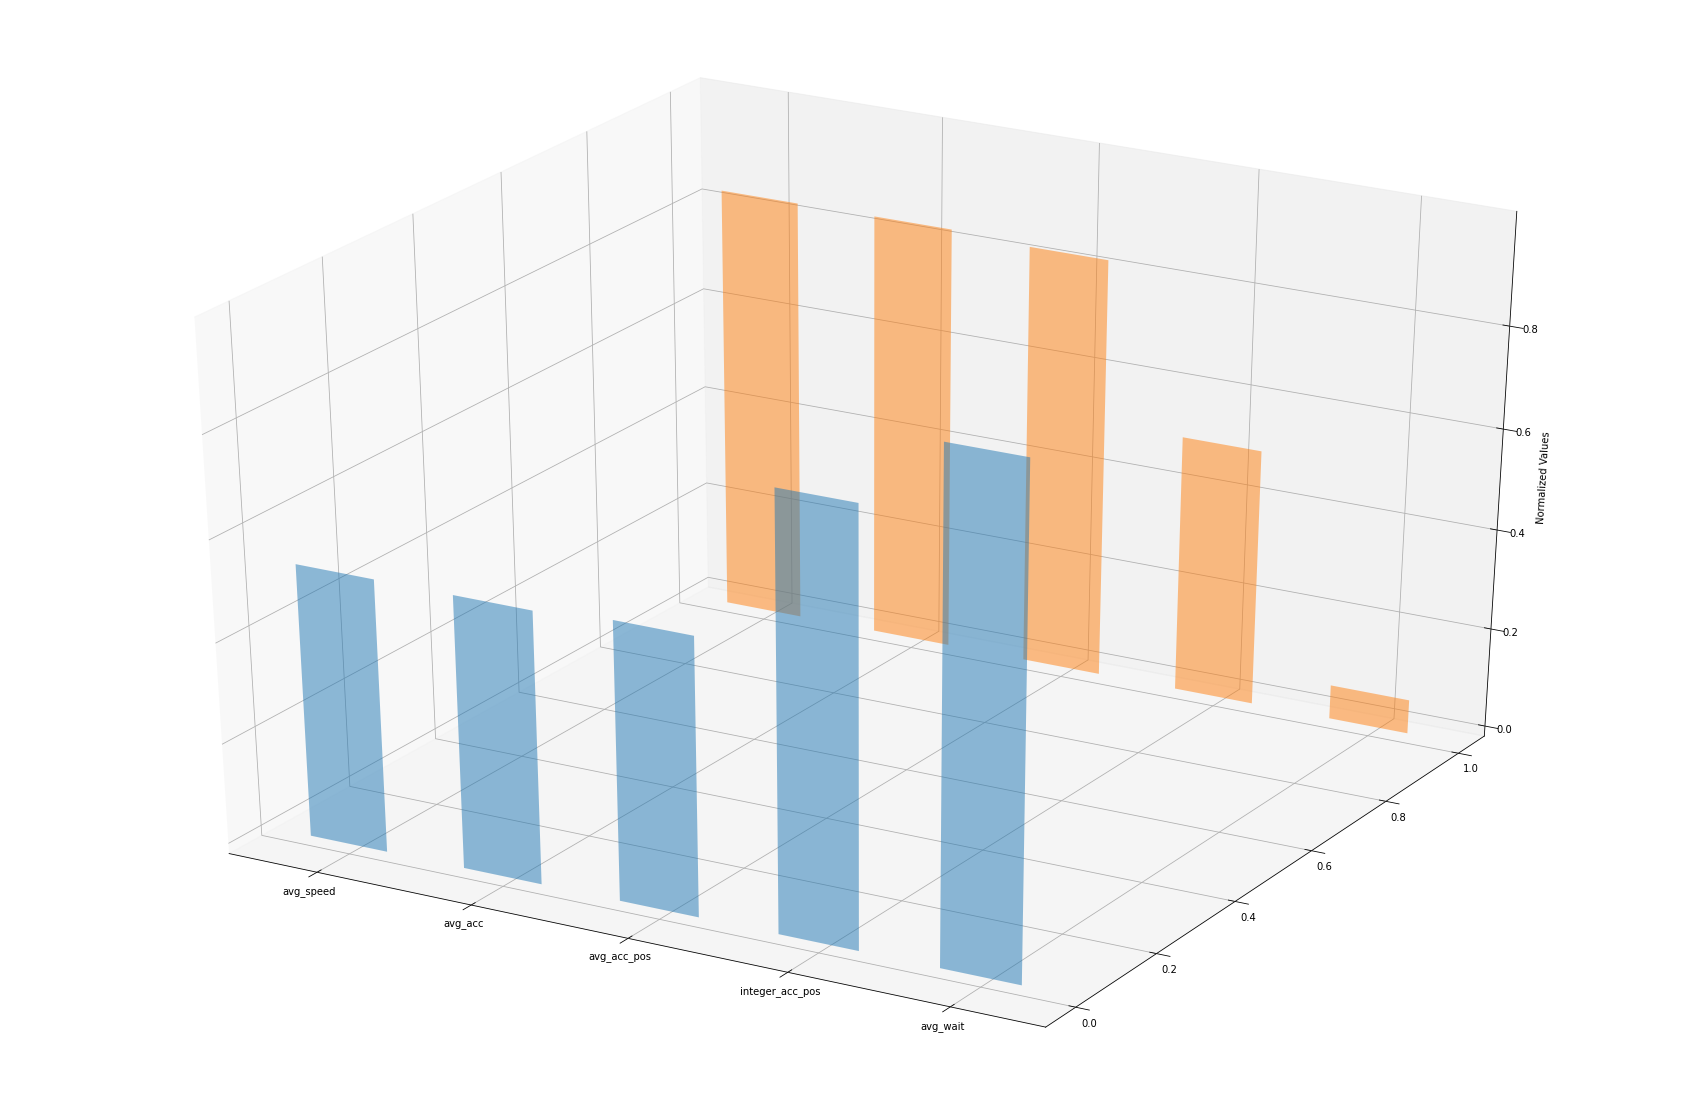

In [ ]:
# DataViz des résultats
df_3d = df_test.transpose() 
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111, projection='3d')

z = list(df_3d)
for n, i in enumerate(df_3d):
    xs = ['avg_speed','avg_acc','avg_acc_pos', 'integer_acc_pos', 'avg_wait'] 
    ys = [i for i in df_3d[i][1:]] 
    zs = z[n]

    ax.bar(xs, ys, zs, zdir='y', alpha=0.5, width=0.5)

ax.set_zlabel('Normalized Values')

plt.show()#